
=== Training and Evaluating: Decision Tree ===

Classification Report:
                 precision    recall  f1-score   support

        Healthy       1.00      1.00      1.00         4
        Monitor       1.00      1.00      1.00        30
Repair Required       1.00      1.00      1.00         3

       accuracy                           1.00        37
      macro avg       1.00      1.00      1.00        37
   weighted avg       1.00      1.00      1.00        37



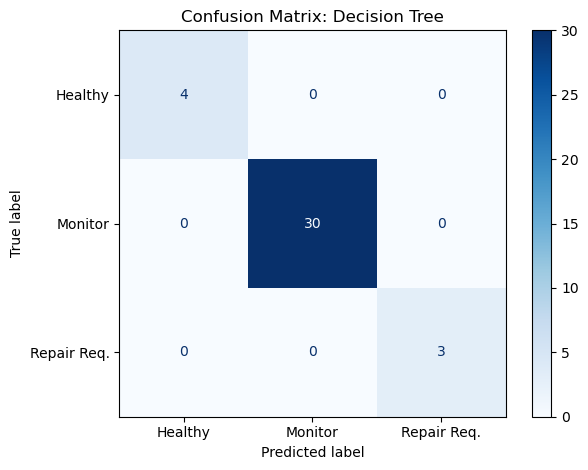


=== Training and Evaluating: Random Forest ===

Classification Report:
                 precision    recall  f1-score   support

        Healthy       1.00      0.75      0.86         4
        Monitor       0.97      1.00      0.98        30
Repair Required       1.00      1.00      1.00         3

       accuracy                           0.97        37
      macro avg       0.99      0.92      0.95        37
   weighted avg       0.97      0.97      0.97        37



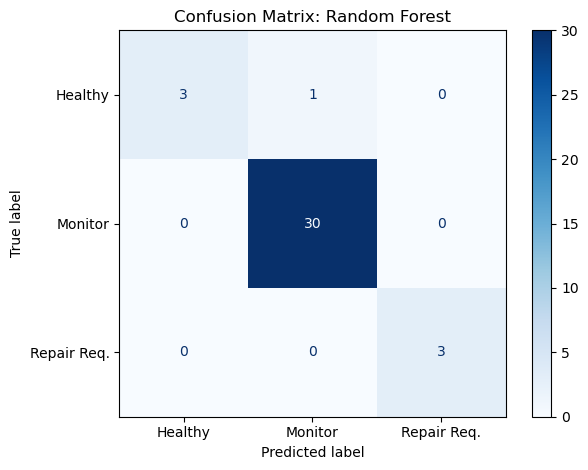


=== Training and Evaluating: SVM (RBF kernel) ===

Classification Report:
                 precision    recall  f1-score   support

        Healthy       0.50      1.00      0.67         4
        Monitor       1.00      0.80      0.89        30
Repair Required       0.60      1.00      0.75         3

       accuracy                           0.84        37
      macro avg       0.70      0.93      0.77        37
   weighted avg       0.91      0.84      0.85        37



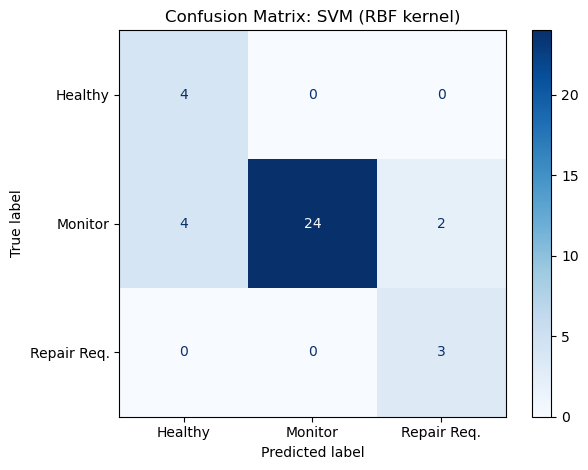

In [2]:
# train_and_evaluate.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


df = pd.read_csv("training data.csv")

X = df.drop(columns=["condition"])
y = df["condition"].map({"Healthy": 0, "Monitor": 1, "Repair Required": 2})

numeric_features = [
    "corrosion rate (Mpy)", "Diameter Size (inch)",
    "Line Length (KM)", "Pigging Frequency (Days)",
    "Surfactant Dosing (Litres)"]
categorical_features = ["Probe Type"]


numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf  = preprocessor.transform(X_test)


models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight="balanced"
    ),
    "SVM (RBF kernel)": SVC(
        kernel="rbf",
        C=1.0,
        probability=True,
        class_weight="balanced",
        random_state=42,
    ),
}


for name, clf in models.items():
    print(f"\n=== Training and Evaluating: {name} ===")
    clf.fit(X_train_tf, y_train)

    y_pred = clf.predict(X_test_tf)

    
    print("\nClassification Report:")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=["Healthy", "Monitor", "Repair Required"],
            zero_division=0,
        )
    )


    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Healthy", "Monitor", "Repair Req."],
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.savefig(f"cm_{name.replace(' ', '_').replace('(', '').replace(')', '')}.png")
    plt.show()
